In [62]:
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error, pauli_error,amplitude_damping_error
from qiskit_aer.noise.errors import phase_amplitude_damping_error
import numpy as np


In [63]:
noise_model = NoiseModel()

# Add depolarizing error with 5% probability for all single qubit gates (u1, u2, u3)
depol_error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3'])

# Add thermal relaxation error (relaxation and dephasing model) ONLY to single-qubit gates
thermal_error = thermal_relaxation_error(0.1, 0.1, 1)  # 10% error probability for relaxation and dephasing
noise_model.add_all_qubit_quantum_error(thermal_error, ['h', 'x', 'z'])  # Apply to single qubit gates

# Add depolarizing error to the 2-qubit gates (such as cx)
depol_2qubit_error = depolarizing_error(0.05, 2)  # 5% depolarizing error on 2-qubit gates
noise_model.add_all_qubit_quantum_error(depol_2qubit_error, ['cx'])

# Add amplitude damping (relaxation error) to simulate energy loss for single-qubit gates
amplitude_damping = amplitude_damping_error(0.1)  # 10% chance of relaxation
noise_model.add_all_qubit_quantum_error(amplitude_damping, ['x', 'z'])


In [64]:
# # Noise parameters
# T1 = 100e3     # Relaxation time (us)
# T2 = 80e3      # Dephasing time (us)
# gate_time_1q = 50  # 1-qubit gate time
# gate_time_2q = 200 # 2-qubit gate time
# crosstalk_prob = 0.01

# # Errors
# thermal_error = phase_amplitude_damping_error(0.01, 0.01)
# relaxation_error_1q = thermal_relaxation_error(T1, T2, gate_time_1q)
# relaxation_error_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(
#     thermal_relaxation_error(T1, T2, gate_time_2q))
# crosstalk_error = depolarizing_error(crosstalk_prob, 2)


# # Noise model
# noise_model = NoiseModel()

# # Apply to each qubit
# for qubit in [0, 1, 2]:
#     noise_model.add_quantum_error(relaxation_error_1q, ['rx', 'h', 'x', 'z'], [qubit])
#     noise_model.add_quantum_error(thermal_error, ['rx', 'h'], [qubit])

# # # Two-qubit gate errors
# # noise_model.add_quantum_error(relaxation_error_2q, ['cx'], [0, 1])
# # noise_model.add_quantum_error(crosstalk_error, ['cx'], [0, 1])


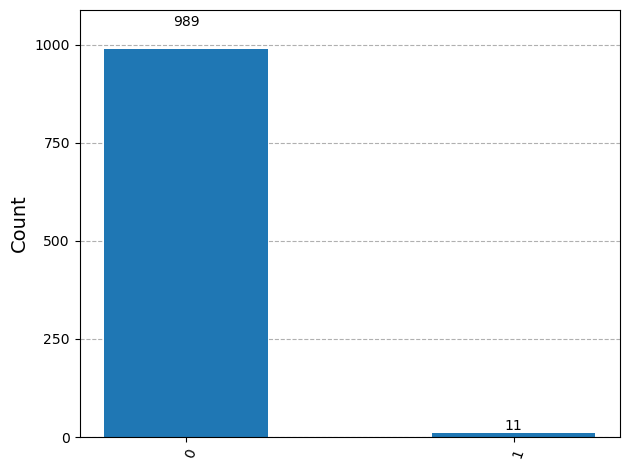

In [65]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit, Clbit
from utils.ibm_lab_util import build_qc


qr = QuantumRegister(3, name="q")
cr = ClassicalRegister(3, name="c")


teleportation_circuit = build_qc(qr, cr)
s, a, b = qr
c0, c1, c2 = cr
teleportation_circuit.measure(b, c2)
teleportation_circuit.draw("mpl")


import math

teleport_superposition_circuit: QuantumCircuit


# Create a circuit that has the same structure as our teleportation circuit
state_prep = QuantumCircuit(qr, cr)

# Prepare the qubit
state_prep.rx(math.pi / 4, s)

# Put a barrier across all of the wires
state_prep.barrier()
# Add the teleportation circuit to the superposition circuit
teleport_superposition_circuit = state_prep.compose(teleportation_circuit)

teleport_superposition_circuit.draw("mpl", cregbundle=False)

# %%
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

sim = AerSimulator()
sim = AerSimulator(noise_model=noise_model)

transpiled_circuit = transpile(teleport_superposition_circuit, sim)

# run job
shots = 1000
job = sim.run(transpiled_circuit, shots=shots, dynamic=True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

# %% [markdown]
# Let's compute the distribution of just Bob's measurement by marginalizing over the other measured bits.

# %%
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts

bobs_counts = marginal_counts(exp_counts, [qr.index(b)])
plot_histogram(bobs_counts)



In [66]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram

# Step 1: Create simulators
ideal_sim = AerSimulator(method="statevector")
noisy_sim = AerSimulator(noise_model=noise_model, method="statevector")  # use your noise_model here

# Step 2: Clone the circuit and add save_statevector
ideal_circuit = teleport_superposition_circuit.copy()
ideal_circuit.save_statevector()

noisy_circuit = transpile(teleport_superposition_circuit, noisy_sim)
noisy_circuit.save_statevector()


# Step 3: Run ideal
ideal_result = ideal_sim.run(ideal_circuit).result()
ideal_sv = ideal_result.get_statevector()

# Step 4: Run noisy
noisy_result = noisy_sim.run(noisy_circuit).result()
noisy_sv = noisy_result.get_statevector()

fidelity = state_fidelity(ideal_sv, noisy_sv)
print(f"Quantum Fidelity: {fidelity:.4f}")


import time
start = time.time()
noisy_sim.run(noisy_circuit).result()
end = time.time()
latency = end - start
print(f"Quantum Latency (sec): {latency:.4f}")


shots = 1000
throughput = shots / latency
print(f"Quantum Throughput (qubits/sec): {throughput:.2f}")



Quantum Fidelity: 0.0000
Quantum Latency (sec): 0.0165
Quantum Throughput (qubits/sec): 60571.94
